# 1. Učitavanje podataka, razumevanje

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
df.shape

(32769, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [6]:
df.nunique()

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [7]:
class_counts = df['ACTION'].value_counts()
print(class_counts)

1    30872
0     1897
Name: ACTION, dtype: int64


Vidimo da je izlazna klasa nebalansirana


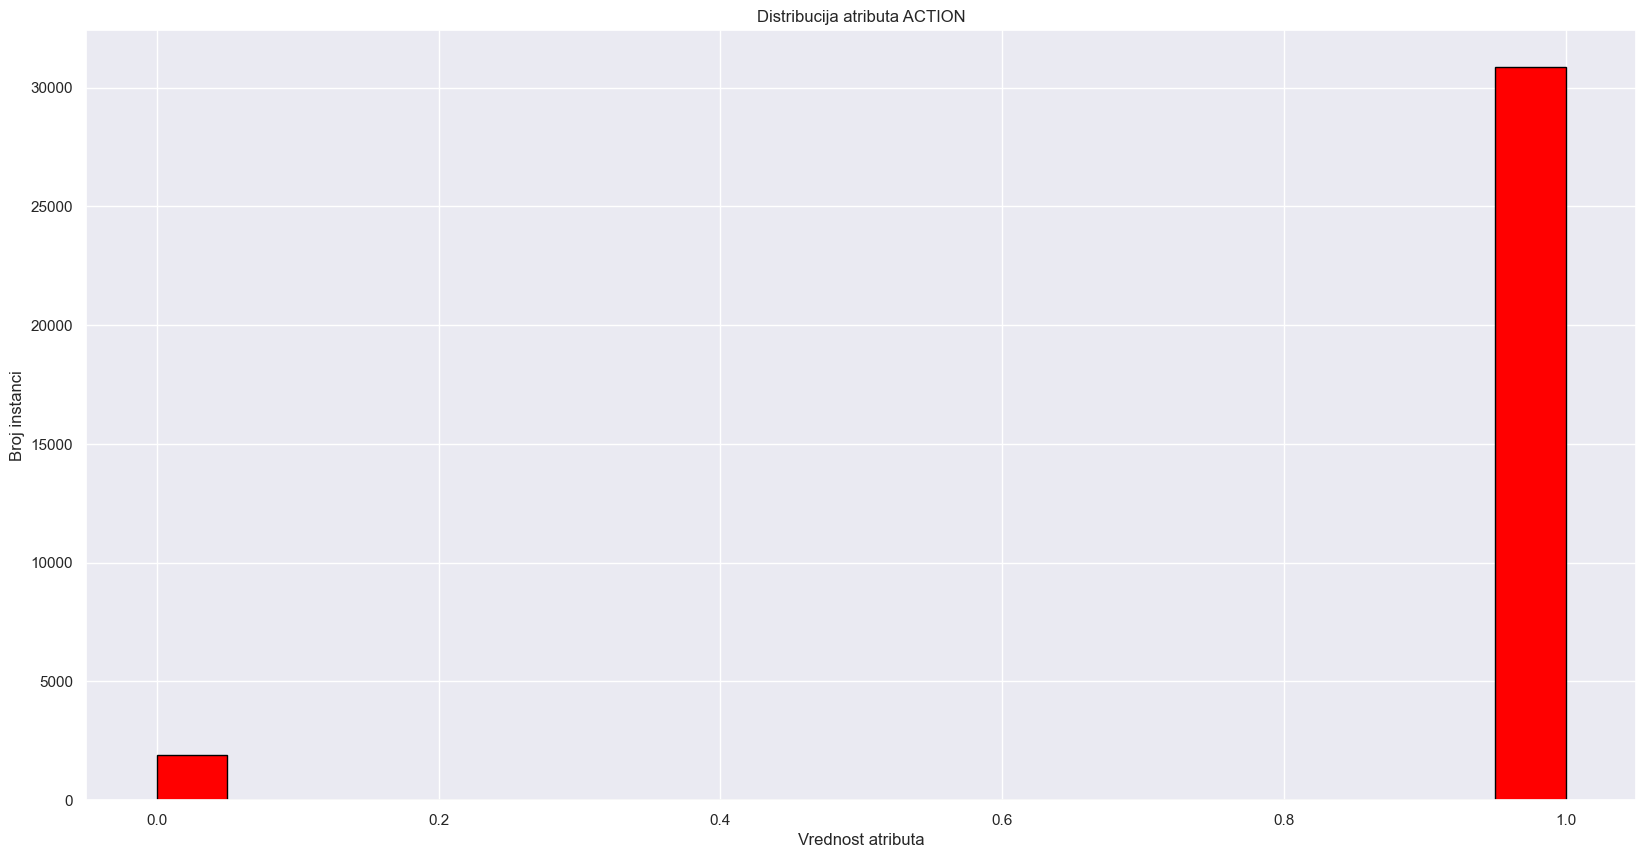

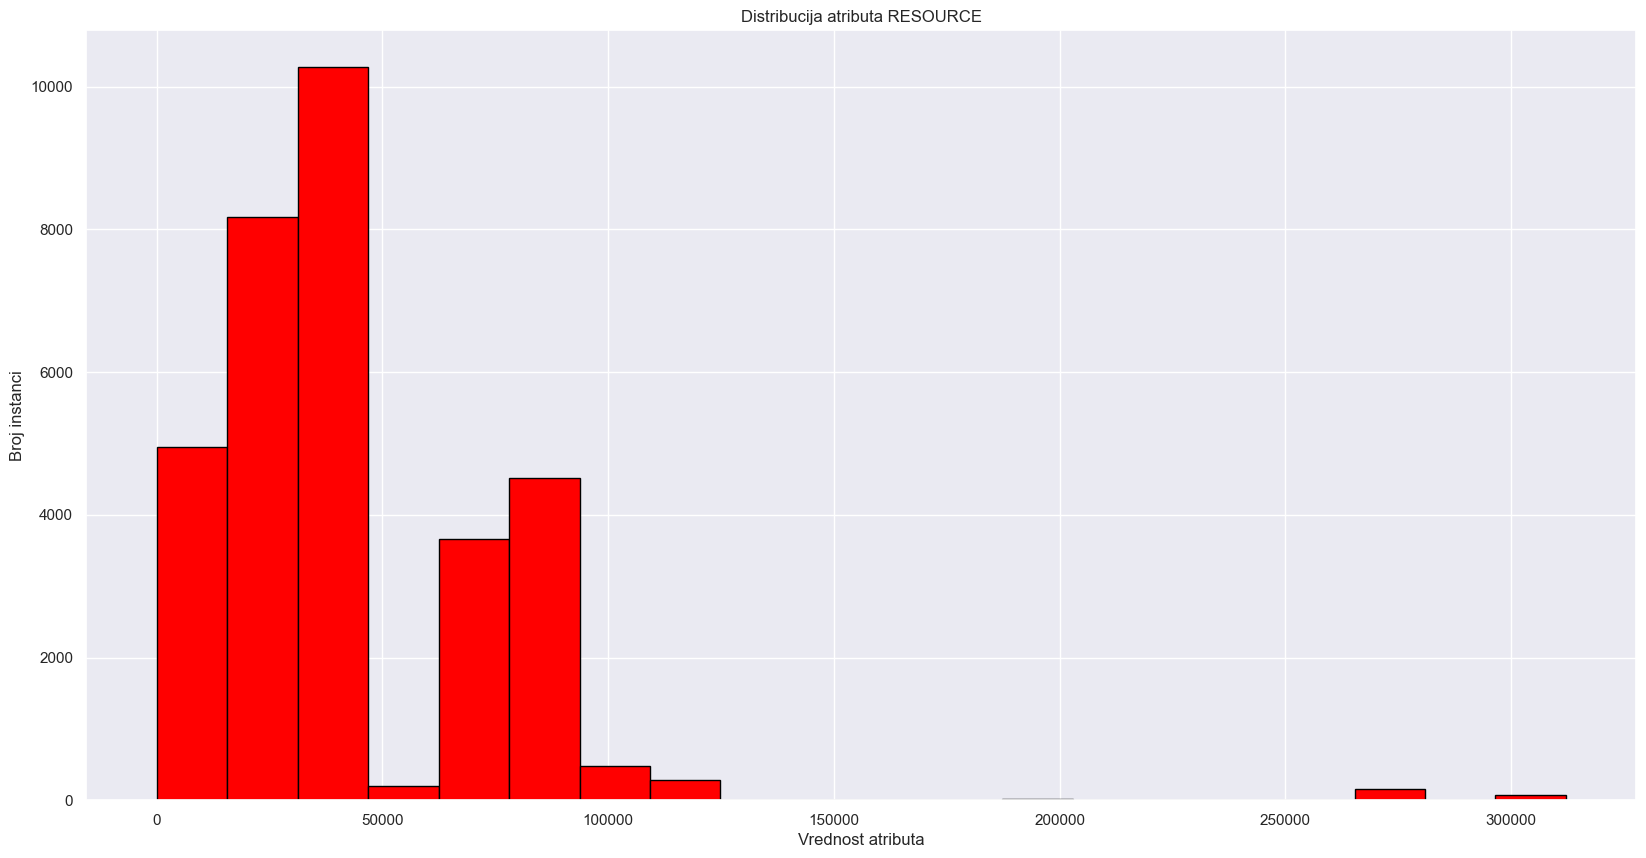

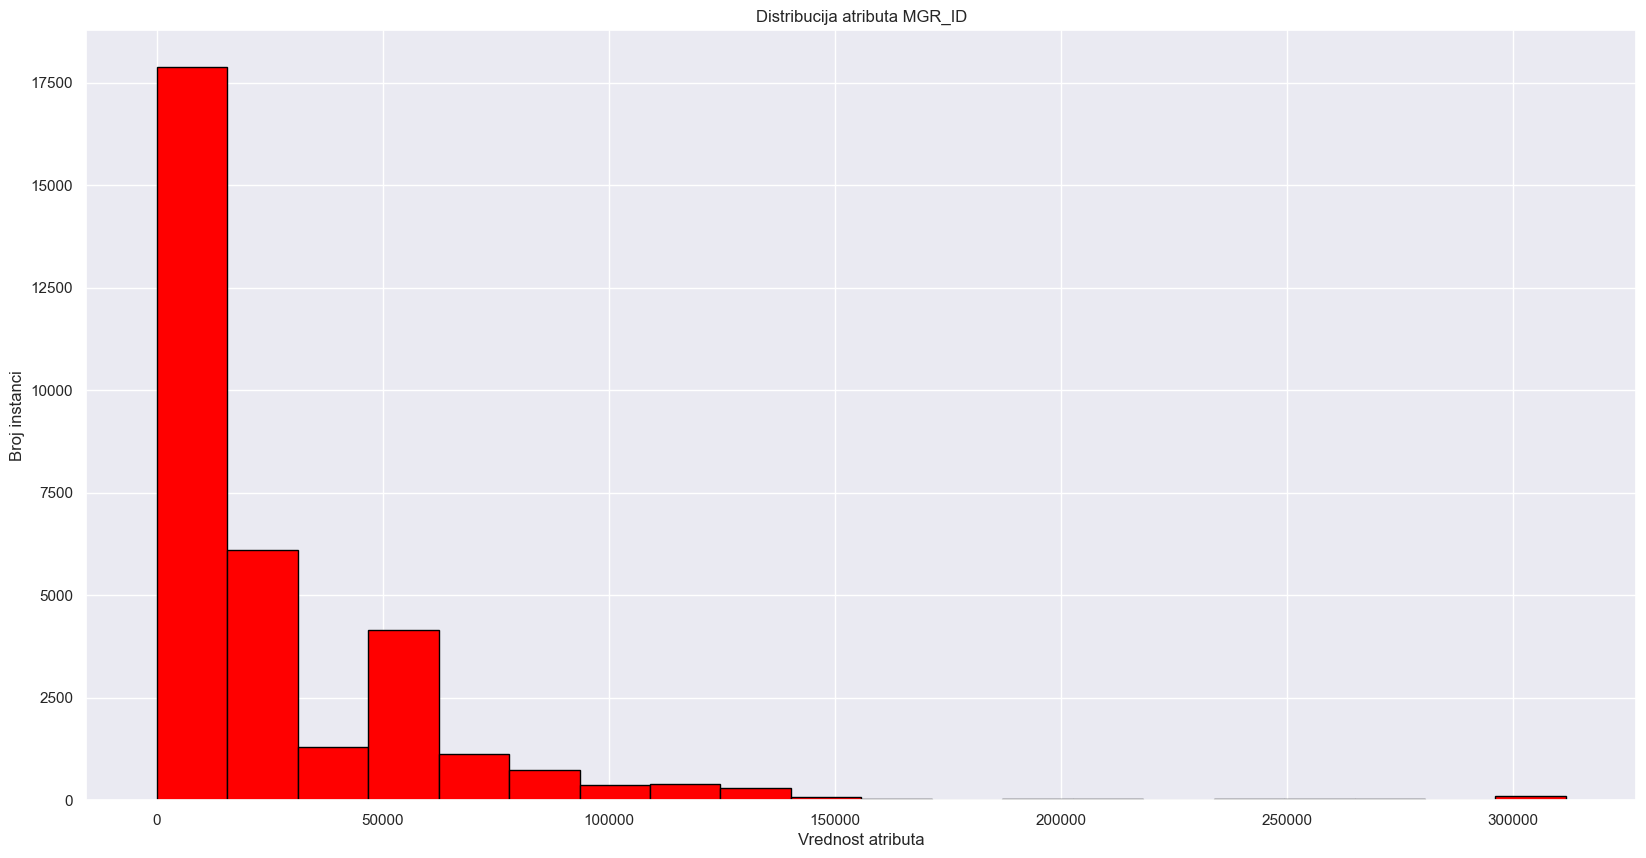

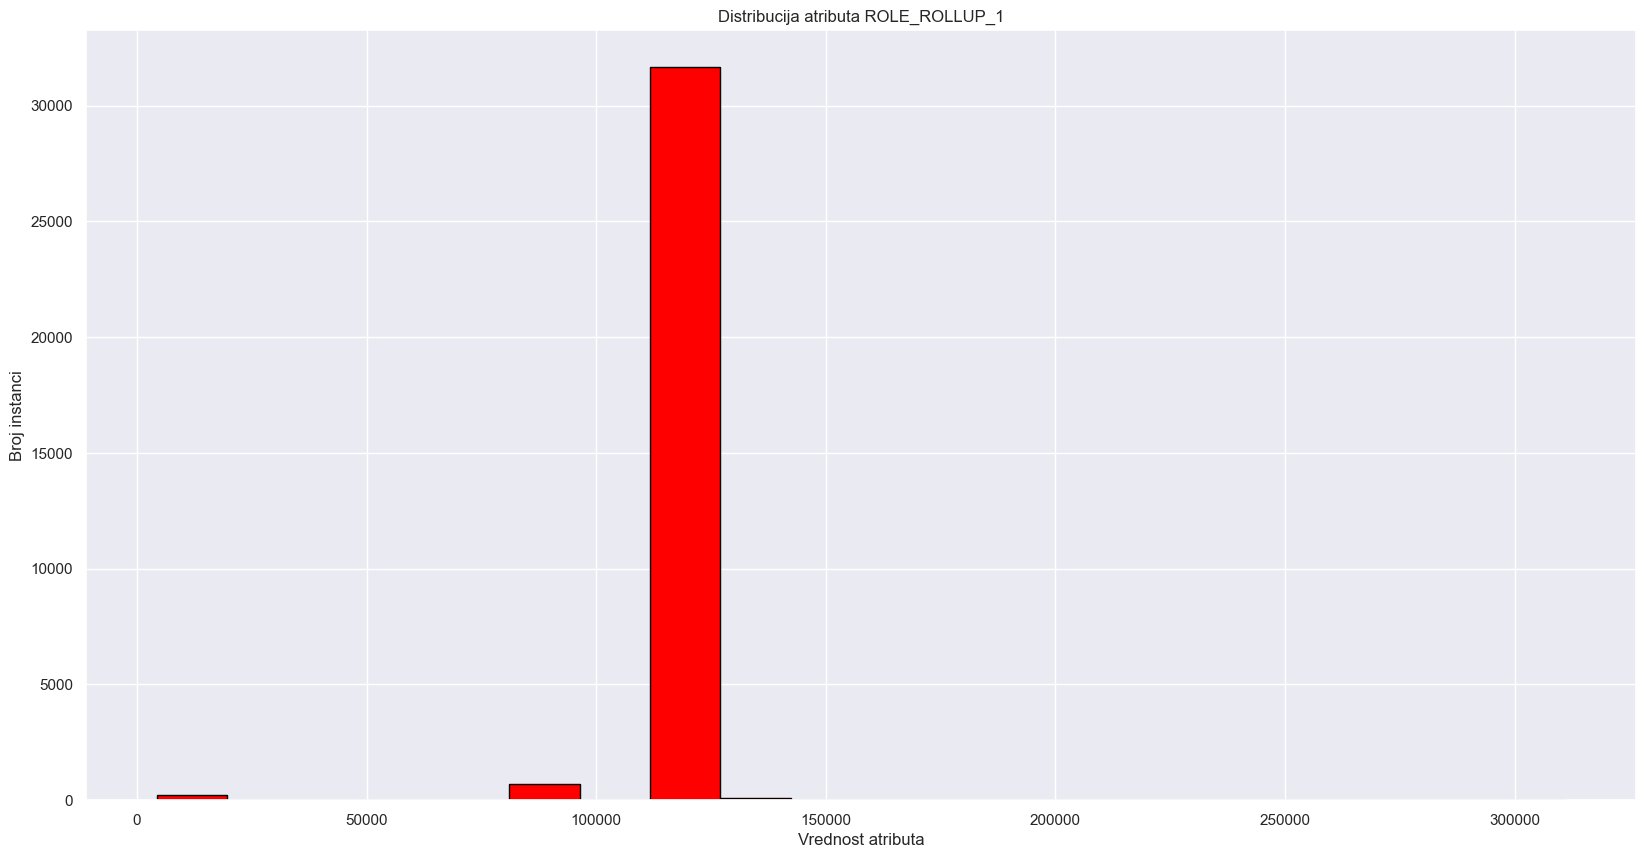

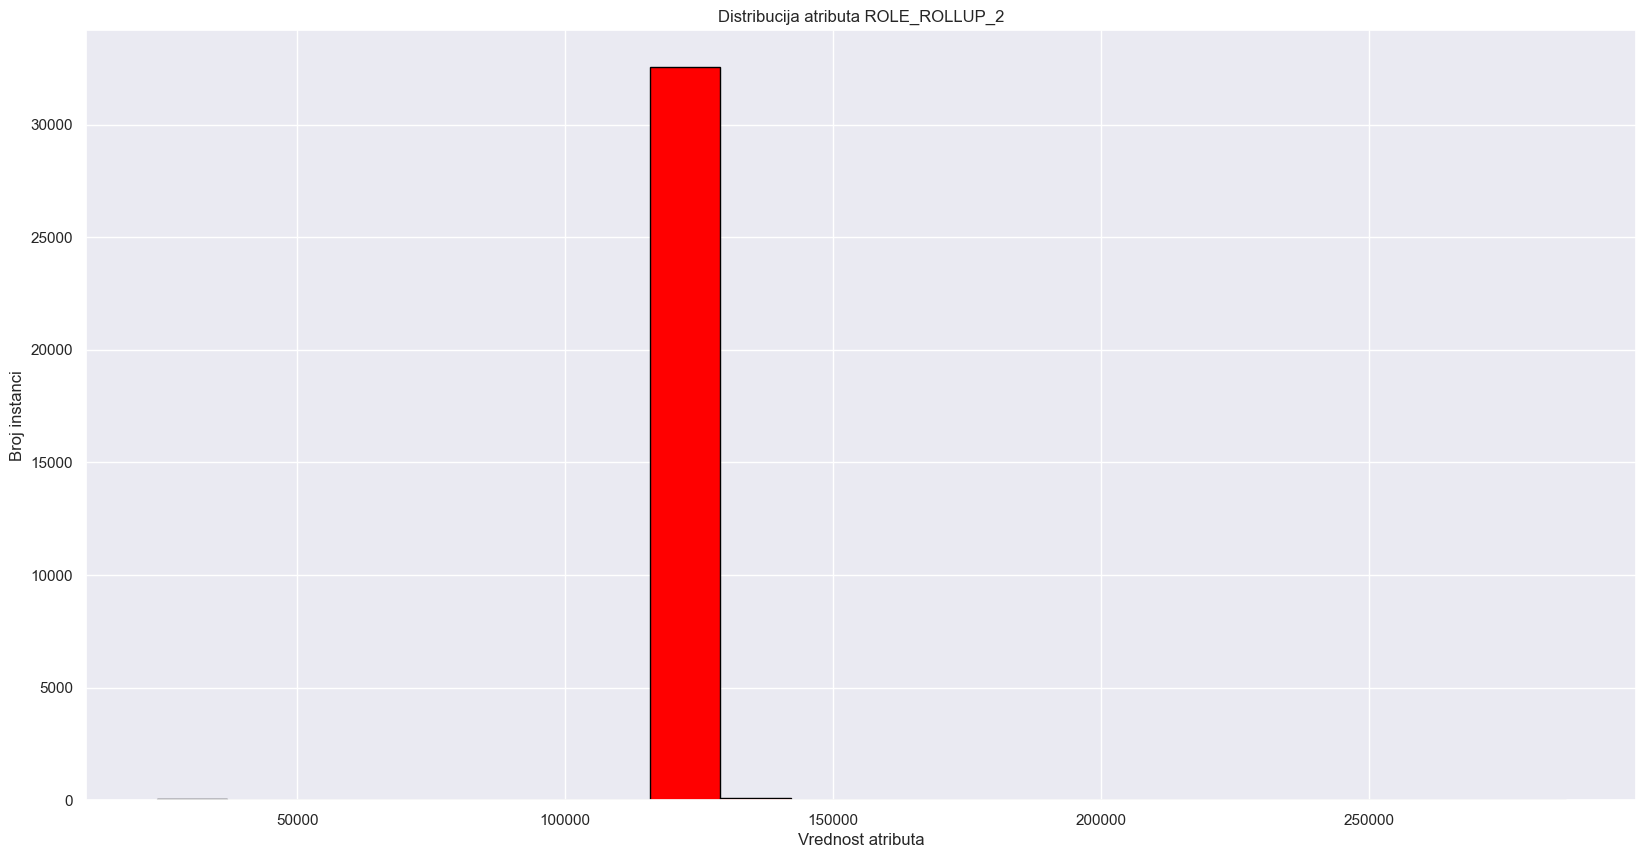

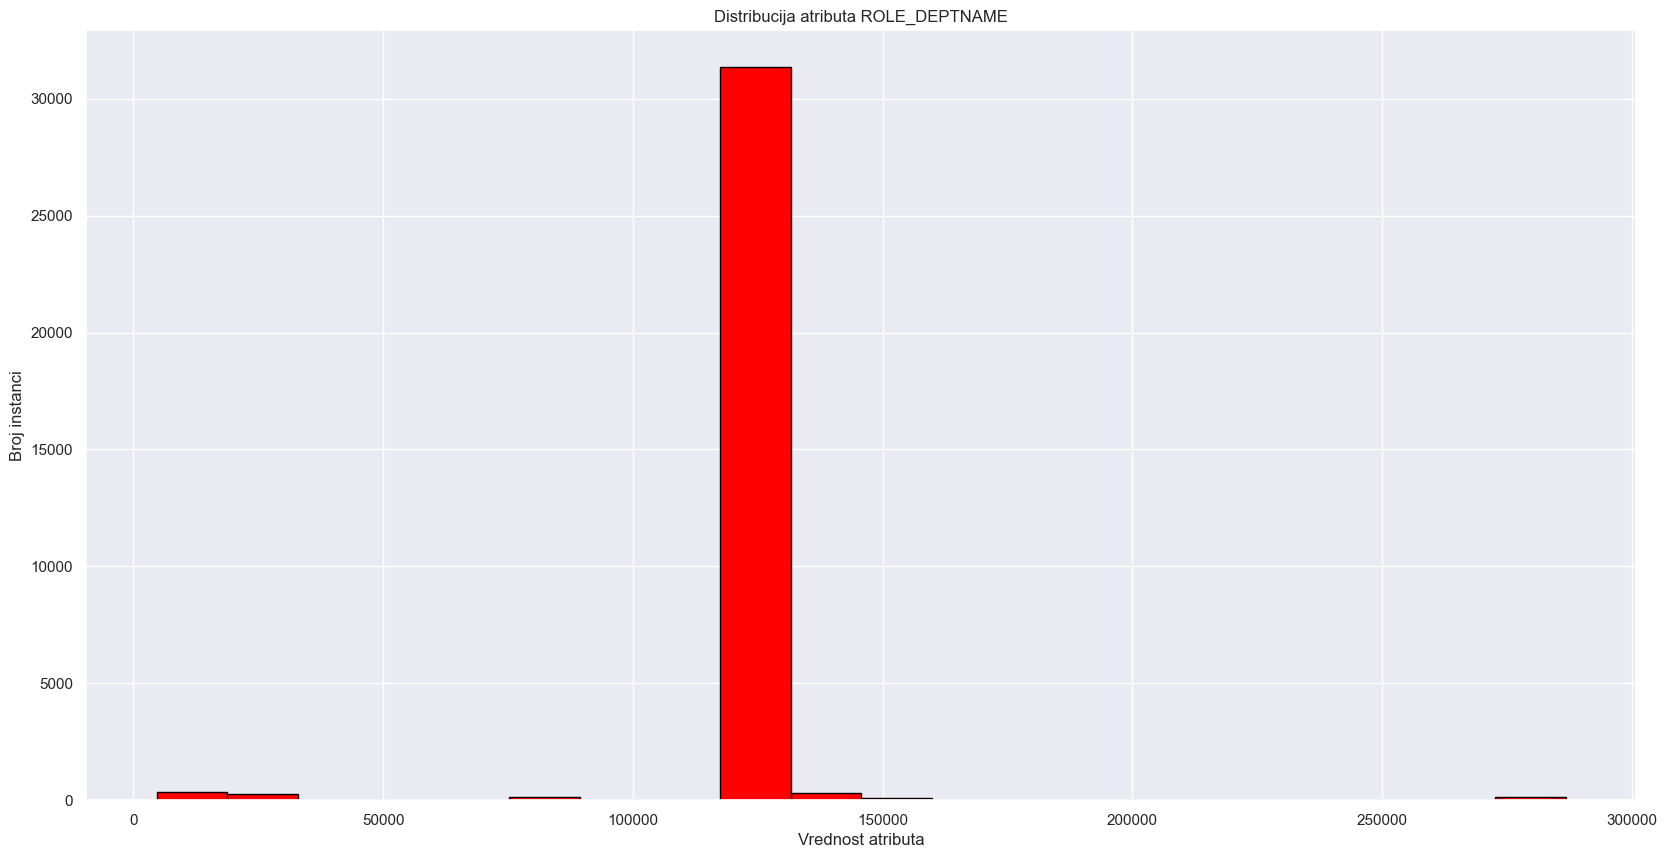

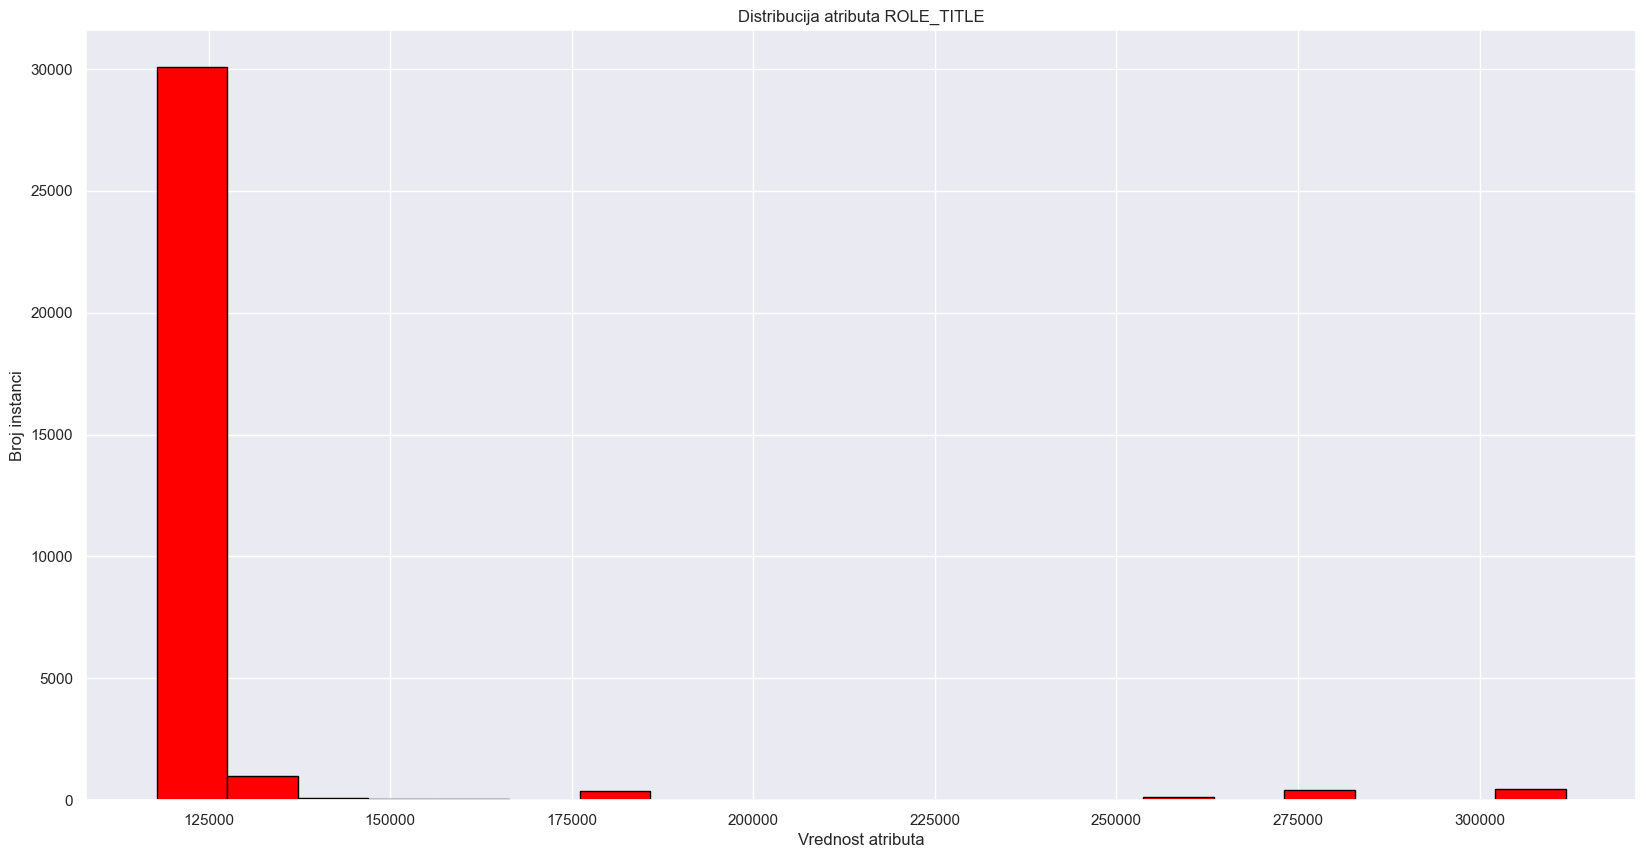

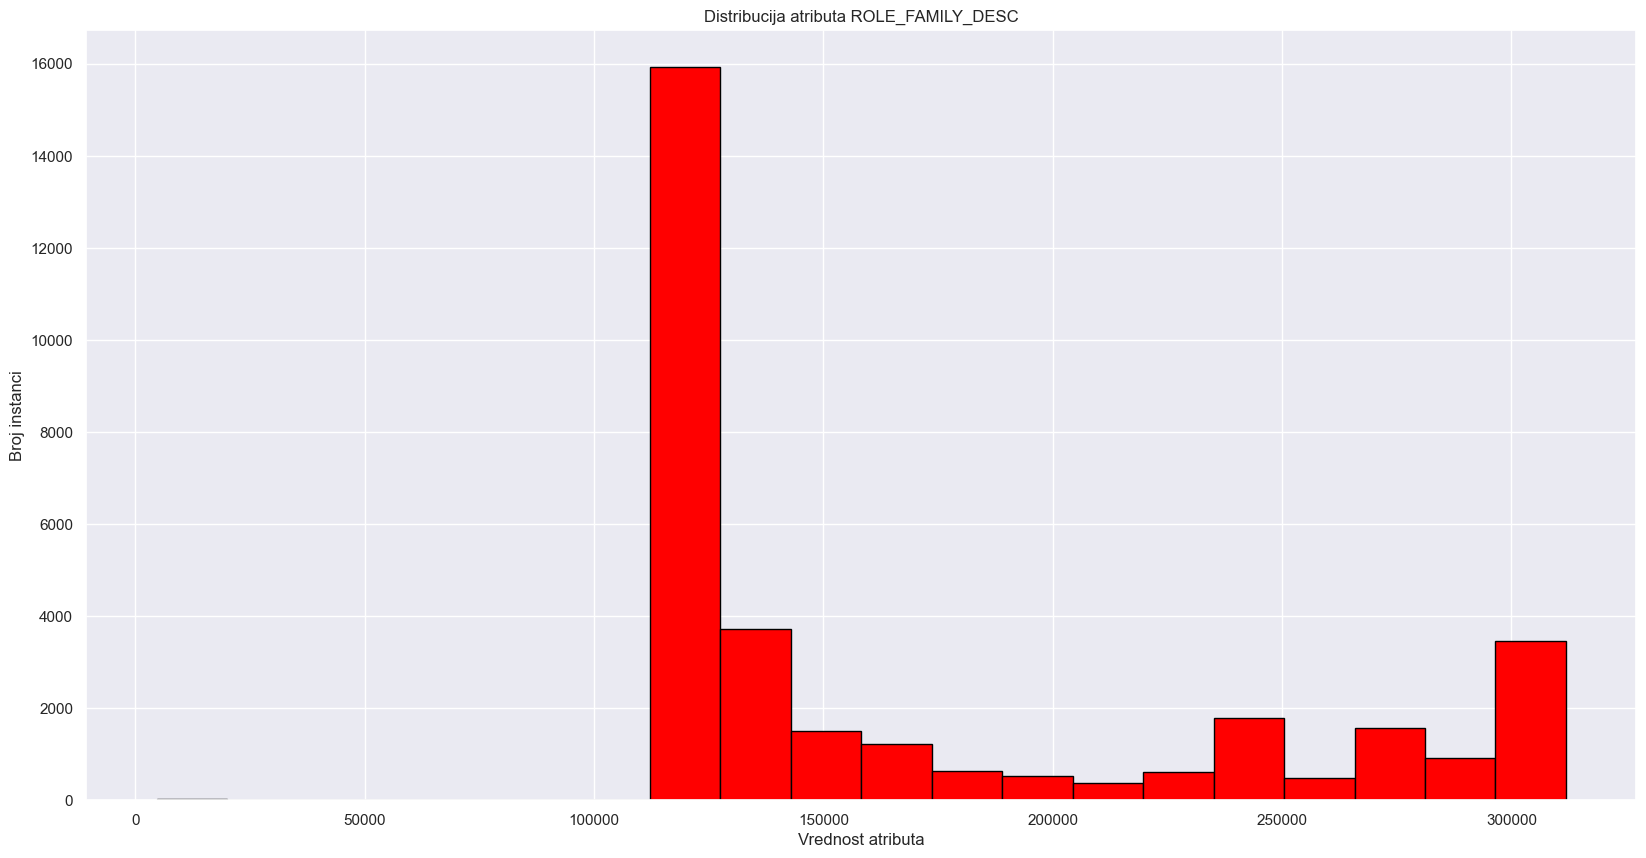

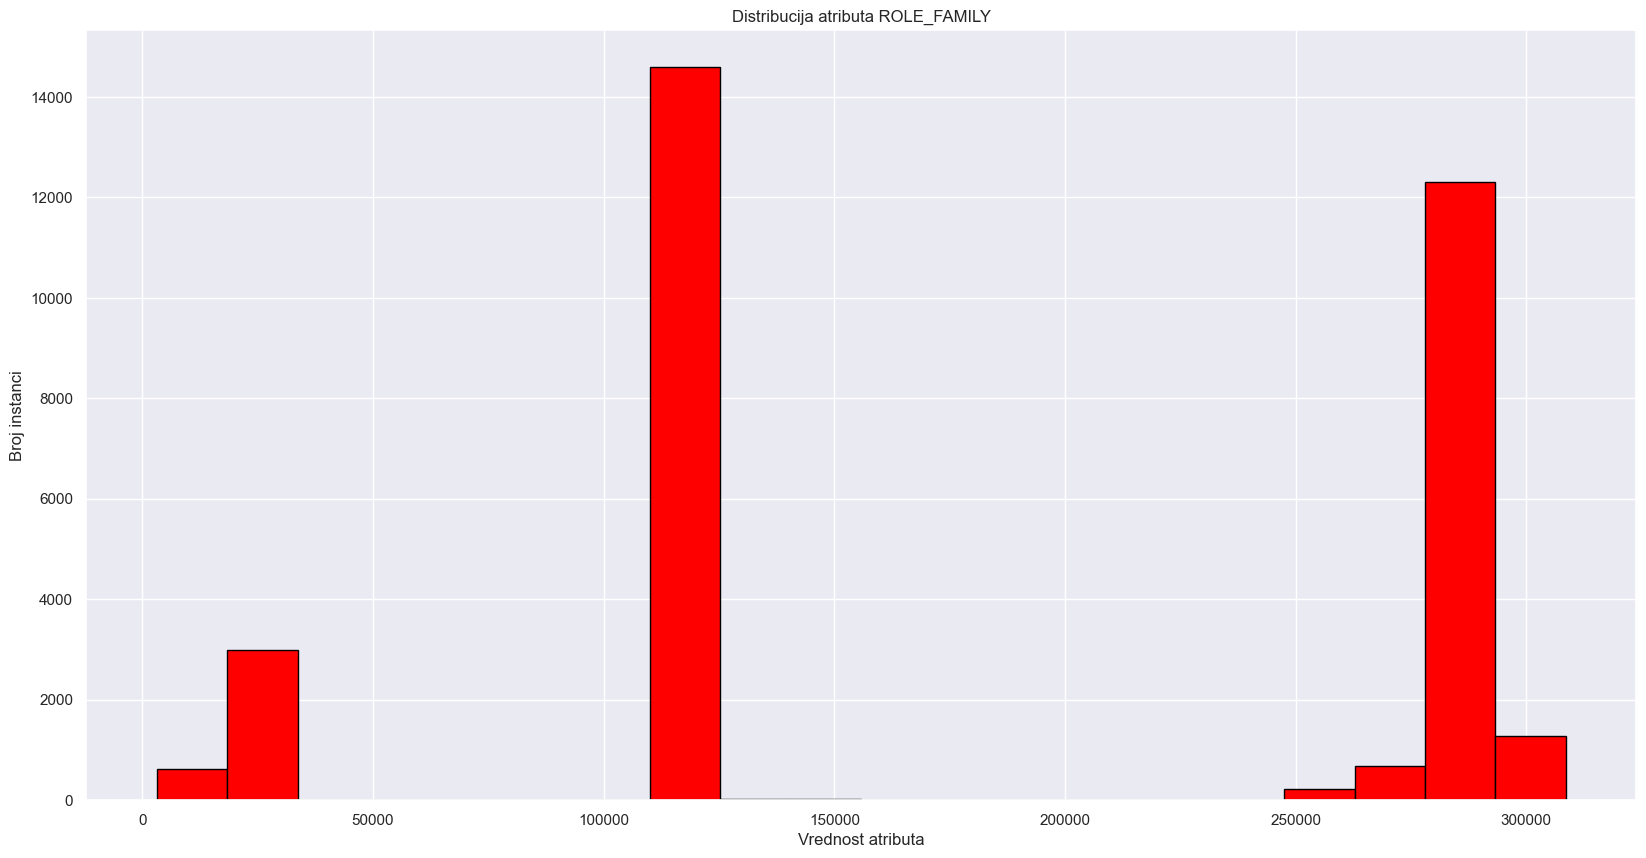

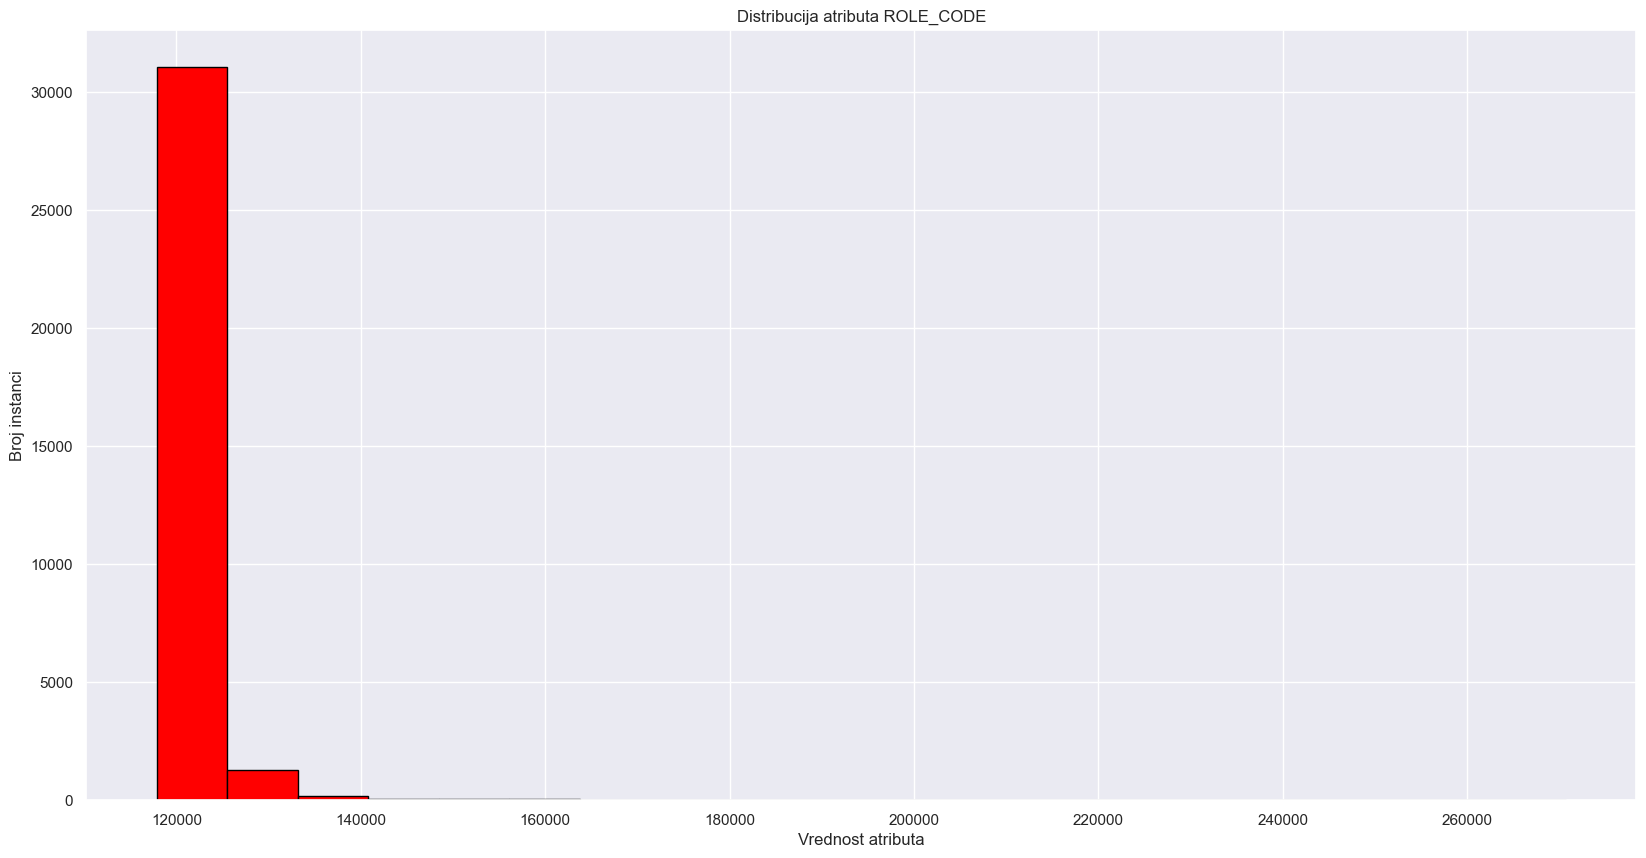

In [8]:
for column in df.columns:
    plt.figure(figsize=(20, 10))
    plt.hist(df[column], bins=20, color='red', edgecolor='black')
    plt.title(f'Distribucija atributa {column}')
    plt.xlabel('Vrednost atributa')
    plt.ylabel('Broj instanci')
    plt.grid(True)
    plt.show()

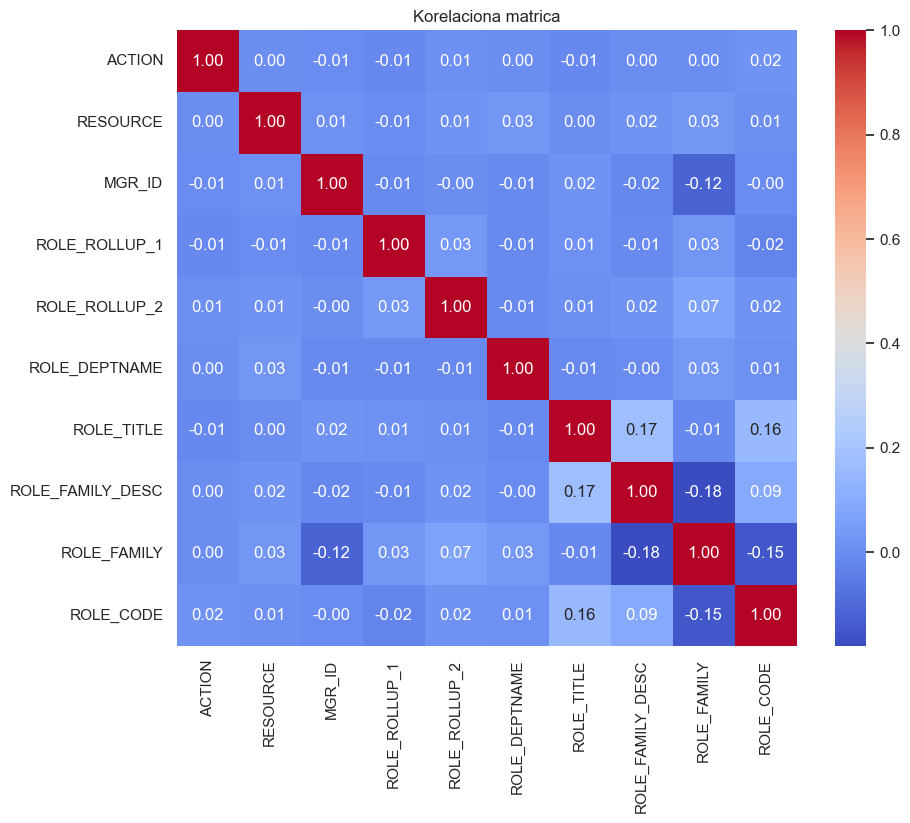

In [9]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelaciona matrica')
plt.show()

In [10]:
df.isnull().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

VIdimo da nema NULL vrednosti

# 2. Priprema podataka

In [11]:
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from category_encoders import CatBoostEncoder


In [12]:
y = df['ACTION']
X = df.drop(columns='ACTION') 


numeric_features = X.select_dtypes(include=['int64']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), numeric_features)
    ],
    remainder='passthrough'
)

selector = SelectKBest(score_func=f_classif, k=400)

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector)
])

X_preprocessed = model_pipeline.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("Dimenzije X_train_resampled:", X_train_resampled.shape)
print("Dimenzije y_train_resampled:", y_train_resampled.shape)
print("Dimenzije X_test:", X_test.shape)
print("Dimenzije y_test:", y_test.shape)

Dimenzije X_train_resampled: (49374, 400)
Dimenzije y_train_resampled: (49374,)
Dimenzije X_test: (6554, 400)
Dimenzije y_test: (6554,)


In [13]:

new_column_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(numeric_features)

print("\nNove dodate kolone:")
print(new_column_names)


Nove dodate kolone:
['RESOURCE_0' 'RESOURCE_38' 'RESOURCE_136' ... 'ROLE_CODE_266863'
 'ROLE_CODE_268610' 'ROLE_CODE_270691']


# 3. PRIMENA MODELA

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score



In [15]:
def plot_feature_importance(feature_columns, importance_values, top_n_features=10):
    feature_imp = [ col for col in zip(feature_columns, importance_values)]
    feature_imp.sort(key=lambda x:x[1], reverse=True)
    
    if top_n_features:
        imp = pd.DataFrame(feature_imp[0:top_n_features], columns=['feature', 'importance'])
    else:
        imp = pd.DataFrame(feature_imp, columns=['feature', 'importance'])
    plt.figure(figsize=(10, 8))
    sns.barplot(y='feature', x='importance', data=imp, orient='h')
    plt.title('Most Important Features', fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xlabel("")
    plt.show()

# STABLO ODLUČIVANJA

In [16]:
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier()

In [17]:
y_pred_proba = model_tree.predict_proba(X_test)[:, 1]  
auc = roc_auc_score(y_test, y_pred_proba)
print('Stablo odlucivanja AUC =', auc)

Stablo odlucivanja AUC = 0.8099267613533047


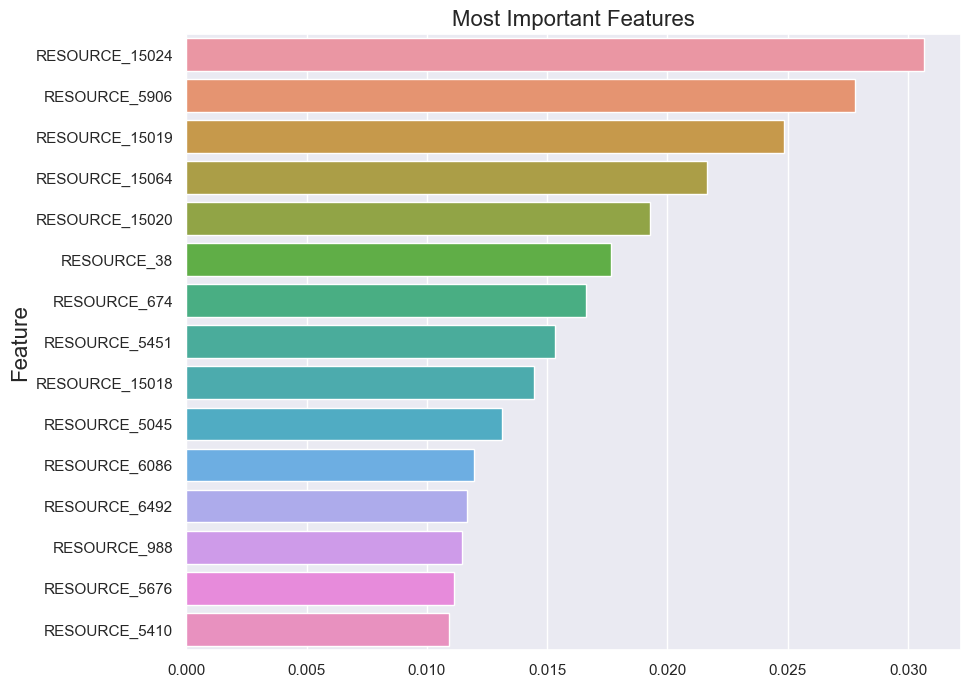

In [18]:
plot_feature_importance(new_column_names, model_tree.feature_importances_, top_n_features=15)

# LOGISTIČKA REGRESIJA

In [19]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [20]:
y_pred_proba = logistic_reg.predict_proba(X_test)[:, 1]  
auc = roc_auc_score(y_test, y_pred_proba)
print('Logisticka regresija AUC =', auc)

Logisticka regresija AUC = 0.8388351046000355


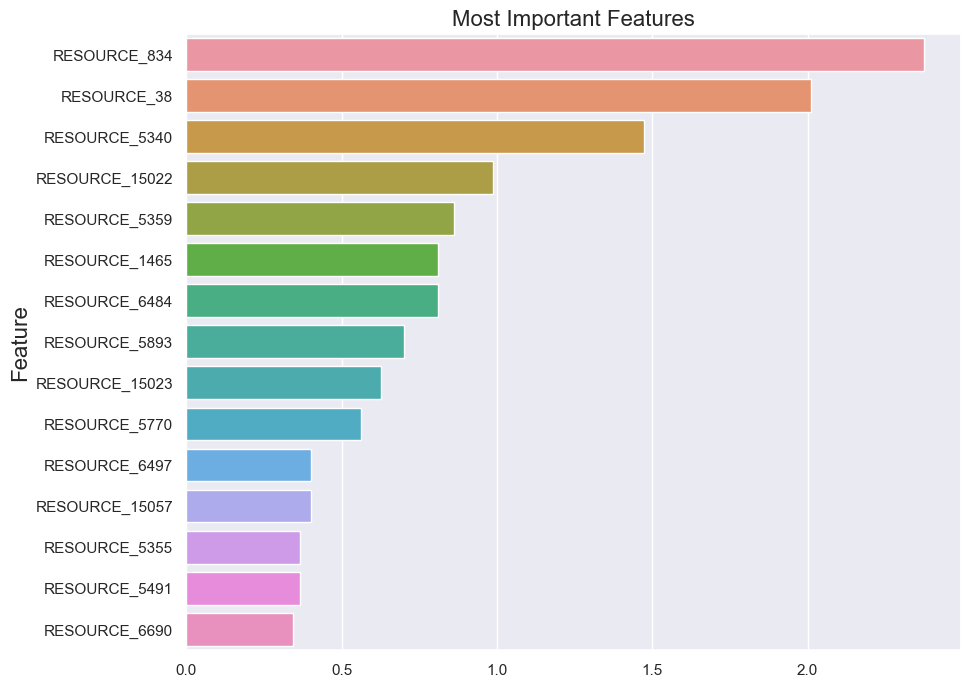

In [21]:
plot_feature_importance(new_column_names, logistic_reg.coef_[0], top_n_features=15)

# KNN

In [22]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier()

In [23]:
y_pred_proba = model_knn.predict_proba(X_test)[:, 1]  
auc = roc_auc_score(y_test, y_pred_proba)
print('KNN AUC =', auc)

KNN AUC = 0.7876633519770929


In [24]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier()

In [25]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_resampled, y_train_resampled)
y_pred_proba = model_knn.predict_proba(X_test)[:, 1]  
auc = roc_auc_score(y_test, y_pred_proba)
print('KNN AUC =', auc)

KNN AUC = 0.7876633519770929


# RANDOM FOREST

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Kreiranje i obučavanje Random Forest modela
model_rf = RandomForestClassifier()
model_rf.fit(X_train_resampled, y_train_resampled)

# Predikcija verovatnoće pripadnosti pozitivnoj klasi
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# Izračunavanje AUC
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# Ispis rezultata
print('Random Forest AUC =', auc_rf)


Random Forest AUC = 0.8270468153347661


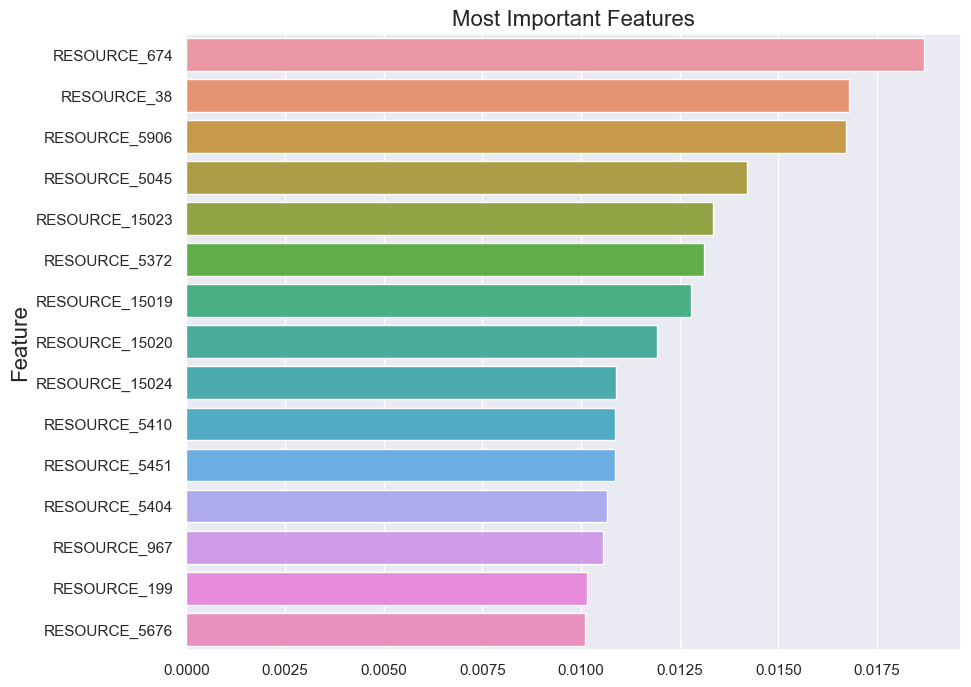

In [27]:
plot_feature_importance(new_column_names, model_rf.feature_importances_, top_n_features=15)

# IZBACUJEMO KNN

In [28]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression()
}

for name, model in models.items():
    
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
    
    print(f"Kros-validacija za {name}:")
    print(f"{name}: AUC = {scores.mean()}")
    print(f"Standardna devijacija AUC za {name}: {scores.std()}")
    print()


Kros-validacija za Random Forest:
Random Forest: AUC = 0.8809634733203129
Standardna devijacija AUC za Random Forest: 0.003286519382214883

Kros-validacija za Decision Tree:
Decision Tree: AUC = 0.8807229025399526
Standardna devijacija AUC za Decision Tree: 0.003497054958626332

Kros-validacija za Logistic Regression:
Logistic Regression: AUC = 0.8515629222233351
Standardna devijacija AUC za Logistic Regression: 0.0030411819861421796



Na osnovu ovih rezultata, možemo primetiti da su Random Forest i Decision Tree modeli postigli slične AUC vrednosti, sa malim razlikama. Oba modela imaju veće AUC vrednosti od Logistic Regression modela. Takođe, primetili smo da su standardne devijacije AUC vrednosti za Random Forest i Decision Tree model veoma male, što ukazuje na to da su ovi modeli stabilni i dosledni u svojim performansama tokom kros-validacije.

Na osnovu ovih informacija, možemo zaključiti da su Random Forest i Decision Tree modeli verovatno bolji izbor od Logistic Regression modela za dati zadatak. Među Random Forest i Decision Tree modela, ne postoji značajna razlika u performansama.

In [43]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rf_model = RandomForestClassifier()
rf_model.fit(X_train_resampled, y_train_resampled)

selected_indices = selector.get_support(indices=True)

one_hot_encoded_features = model_pipeline.named_steps['preprocessor'].transformers_[0][1]\
                            .get_feature_names_out(input_features=numeric_features)

selected_features = one_hot_encoded_features[selected_indices]

importances = rf_model.feature_importances_

coef_df = pd.DataFrame({'Atribut': selected_features, 'imp': importances})


print(coef_df.head(30))

           Atribut       imp
0     RESOURCE_710  0.000155
1    RESOURCE_4675  0.016538
2    RESOURCE_6497  0.000864
3   RESOURCE_14925  0.002500
4   RESOURCE_15668  0.000414
5   RESOURCE_18072  0.009731
6   RESOURCE_18378  0.002075
7   RESOURCE_18411  0.000665
8   RESOURCE_18913  0.002965
9   RESOURCE_19712  0.000161
10  RESOURCE_20218  0.000623
11  RESOURCE_20222  0.001849
12  RESOURCE_20270  0.001214
13  RESOURCE_20287  0.001004
14  RESOURCE_20897  0.018090
15  RESOURCE_21447  0.001201
16  RESOURCE_21751  0.006443
17  RESOURCE_22956  0.005977
18  RESOURCE_23465  0.002892
19  RESOURCE_25816  0.002503
20  RESOURCE_25857  0.001928
21  RESOURCE_27396  0.000000
22  RESOURCE_27416  0.007902
23  RESOURCE_27831  0.000462
24  RESOURCE_28310  0.002066
25  RESOURCE_28534  0.001151
26  RESOURCE_29260  0.002242
27  RESOURCE_29954  0.000000
28  RESOURCE_30835  0.000000
29  RESOURCE_32642  0.004313


In [30]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

logreg_model = LogisticRegression()
logreg_model.fit(X_train_resampled, y_train_resampled)

selected_indices = selector.get_support(indices=True)

one_hot_encoded_features = model_pipeline.named_steps['preprocessor'].transformers_[0][1]\
                            .get_feature_names_out(input_features=numeric_features)

selected_features = one_hot_encoded_features[selected_indices]

coefficients = logreg_model.coef_[0]

coef_df = pd.DataFrame({'Atribut': selected_features, 'Koeficijent': coefficients})

coef_df['Apsolutni_Koeficijent'] = coef_df['Koeficijent'].abs()

coef_df = coef_df.sort_values(by='Apsolutni_Koeficijent', ascending=False)

print(coef_df.head(15))

                     Atribut  Koeficijent  Apsolutni_Koeficijent
104              MGR_ID_8698    -5.343825               5.343825
155             MGR_ID_27759    -4.319693               4.319693
79               MGR_ID_3811    -4.081237               4.081237
100              MGR_ID_6273    -3.959599               3.959599
17            RESOURCE_22956    -3.951359               3.951359
16            RESOURCE_21751    -3.908677               3.908677
126             MGR_ID_17614    -3.903310               3.903310
73               MGR_ID_2837    -3.895038               3.895038
66               MGR_ID_1725    -3.867612               3.867612
89               MGR_ID_4743    -3.824772               3.824772
87               MGR_ID_4626    -3.734653               3.734653
167             MGR_ID_46704    -3.670460               3.670460
48            RESOURCE_75214    -3.651595               3.651595
371  ROLE_FAMILY_DESC_311064    -3.611103               3.611103
368  ROLE_FAMILY_DESC_292

In [31]:
from sklearn.linear_model import LogisticRegression

models = {
    'RF': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression()
}

for name, model in models.items():

    model.fit(X_train_resampled, y_train_resampled)

    y_train_pred_proba = model.predict_proba(X_train_resampled)[:, 1]

    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train_resampled, y_train_pred_proba)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)

    print(f"{name}:")
    print("AUC na trening skupu:", train_auc)
    print("AUC na test skupu:", test_auc)

    overfitting = train_auc - test_auc
    print("Razlika u AUC-u (overfitting):", overfitting)
    print()

RF:
AUC na trening skupu: 0.8856329308728896
AUC na test skupu: 0.8261821041815915
Razlika u AUC-u (overfitting): 0.059450826691298087

Decision Tree:
AUC na trening skupu: 0.8859213180838412
AUC na test skupu: 0.8071908827414871
Razlika u AUC-u (overfitting): 0.07873043534235413

Logistic Regression:
AUC na trening skupu: 0.8536580683887716
AUC na test skupu: 0.8388351046000355
Razlika u AUC-u (overfitting): 0.014822963788736043



Random Forest i Decision Tree modeli imaju veće AUC vrednosti na trening skupu u poređenju sa Logističkom regresijom, što sugeriše da ovi modeli imaju veću sposobnost generalizacije i bolje reprezentuju podatke.
Međutim, Random Forest model ima veću razliku u AUC između trening i test skupa u poređenju sa Decision Tree modelom, što ukazuje na veći nivo prenaučenosti (overfitting) u Random Forest modelu.
Logistička regresija ima najmanju razliku u AUC između trening i test skupa, što sugeriše na manje prenaučenosti u poređenju sa Random Forest i Decision Tree modelima.
Međutim, AUC vrednost Logističke regresije na test skupu je blago manja od AUC vrednosti Decision Tree modela, što može ukazivati na to da je Logistička regresija malo manje sposobna da reprezentuje složenije obrasce u podacima.

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy.stats

# Definisanje raspodela parametara
params = {
    "penalty": ['l1', 'l2'],  # nabrojive vrednosti (kategoricka raspodela)
    #"C": scipy.stats.expon(scale=10)  # eksponencijalna raspodela
    "C": scipy.stats.uniform(0.001,2)  # uniformna raspodela
}

n_iter_search = 100  # broj uzoraka razlicitih vrednosti parametara

# Inicijalizacija RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_distributions=params,
    n_iter=n_iter_search,
    cv=5,
    scoring='roc_auc'
)

# Pokretanje pretrage
random_search.fit(X_train_resampled, y_train_resampled)

# Najbolji model
best_model_log_random = random_search.best_estimator_

# Najbolji parametri
best_params_random = random_search.best_params_

# AUC na trening skupu (najbolji model)
best_train_auc_random = random_search.best_score_

# AUC na test skupu (najbolji model)
best_test_auc_random = roc_auc_score(y_test, best_model_log_random.predict_proba(X_test)[:, 1])

# Ispis rezultata
print("Najbolji parametri:", best_params_random)
print("AUC na trening skupu (najbolji model):", best_train_auc_random)
print("AUC na test skupu (najbolji model):", best_test_auc_random)

Najbolji parametri: {'C': 1.9940630940864719, 'penalty': 'l1'}
AUC na trening skupu (najbolji model): 0.8541851069280064
AUC na test skupu (najbolji model): 0.8358797072206778


In [34]:
param_grid = {
    'max_depth': [7, 10, 13],
    'min_samples_split': [2, 3 , 5, 7,10],
    'min_samples_leaf': [1, 2, 3, 4, 6]
}

decision_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(X_train_resampled, y_train_resampled)

best_model_tree = grid_search.best_estimator_

best_params = grid_search.best_params_

train_auc = roc_auc_score(y_train_resampled, best_model_tree.predict_proba(X_train_resampled)[:, 1])
test_auc = roc_auc_score(y_test, best_model_tree.predict_proba(X_test)[:, 1])

print("Najbolji parametri:", best_params)
print("AUC na trening skupu (najbolji model):", train_auc)
print("AUC na test skupu (najbolji model):", test_auc)

Najbolji parametri: {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 10}
AUC na trening skupu (najbolji model): 0.6977986795128691
AUC na test skupu (najbolji model): 0.671843979555398


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

param_grid = {
    'n_estimators': [50, 100, 200],    # broj stabala u Random Forest-u
    'max_depth': [7, 10, 13],           # maksimalna dubina stabala
    'min_samples_split': [2, 3, 5, 7, 10],  # minimalni broj uzoraka potreban za podelu čvora
    'min_samples_leaf': [1, 2, 3, 4, 6]     # minimalni broj uzoraka potreban za list
}

random_forest = RandomForestClassifier()

grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(X_train_resampled, y_train_resampled)

best_model_forest = grid_search.best_estimator_

best_params = grid_search.best_params_

train_auc = roc_auc_score(y_train_resampled, best_model_forest.predict_proba(X_train_resampled)[:, 1])
test_auc = roc_auc_score(y_test, best_model_forest.predict_proba(X_test)[:, 1])

print("Najbolji parametri:", best_params)
print("AUC na trening skupu (najbolji model):", train_auc)
print("AUC na test skupu (najbolji model):", test_auc) 

Najbolji parametri: {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
AUC na trening skupu (najbolji model): 0.8011815656735743
AUC na test skupu (najbolji model): 0.774809673723253


In [36]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression


voting_clf = VotingClassifier(estimators=[
    ('rf', best_model_forest),
    ('decision_tree', best_model_tree),
    ('logistic_regression', LogisticRegression())
], voting='soft')  

voting_clf.fit(X_train_resampled, y_train_resampled)

y_pred_proba_voting = voting_clf.predict_proba(X_test)[:, 1]

voting_auc = roc_auc_score(y_test, y_pred_proba_voting)
print("AUC za VotingClassifier:", voting_auc)

AUC za VotingClassifier: 0.8351308897082503


In [37]:
voting_scores = cross_val_score(voting_clf, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')

print("Kros-validacija za VotingClassifier:")
print(f"AUC: {voting_scores.mean()}")
print(f"Standardna devijacija AUC: {voting_scores.std()}")

Kros-validacija za VotingClassifier:
AUC: 0.8506838793713491
Standardna devijacija AUC: 0.0030358200265947523


In [38]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

base_models = [
    ('RF', best_model_forest),
    ('decision_tree', best_model_tree),
    ('logistic_regression', LogisticRegression())
]

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

stacking_clf.fit(X_train_resampled, y_train_resampled)

y_pred_proba_stacking = stacking_clf.predict_proba(X_test)[:, 1]

stacking_auc = roc_auc_score(y_test, y_pred_proba_stacking)
print("AUC za StackingClassifier:", stacking_auc)

AUC za StackingClassifier: 0.8388403625345873


# EVALUACIJA

In [39]:
from sklearn.metrics import roc_curve
def plot_custom_roc_curve(clf_name, y_true, y_scores):
    auc_score = np.round(roc_auc_score(y_true, y_scores), 3)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, linewidth=2, label=clf_name+" (AUC Score: {})".format(str(auc_score)))
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("FP", fontsize=16)
    plt.ylabel("TP", fontsize=16)
    plt.legend()

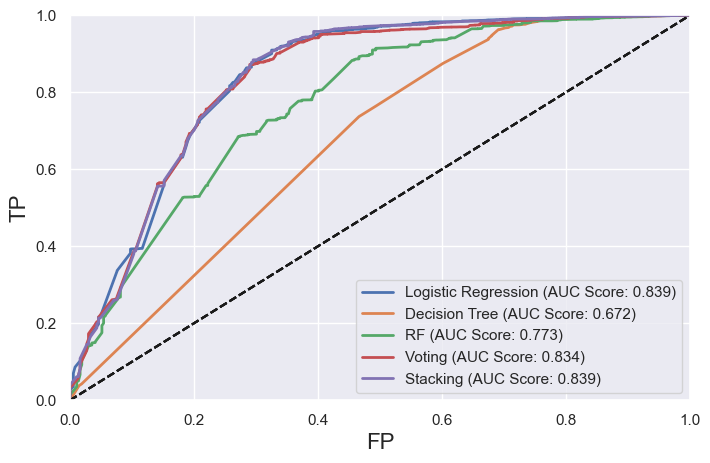

In [40]:
logistic_reg = LogisticRegression()

best_model_forest.fit(X_train_resampled,y_train_resampled)
logistic_reg.fit(X_train_resampled,y_train_resampled)
voting_clf.fit(X_train_resampled, y_train_resampled)

plt.figure(figsize=(8, 5))
plot_custom_roc_curve('Logistic Regression', y_test, logistic_reg.decision_function(X_test))
plot_custom_roc_curve('Decision Tree', y_test, best_model_tree.predict_proba(X_test)[:,1])
plot_custom_roc_curve('RF', y_test, best_model_forest.predict_proba(X_test)[:,1])
plot_custom_roc_curve('Voting', y_test, voting_clf.predict_proba(X_test)[:,1])
plot_custom_roc_curve('Stacking', y_test, stacking_clf.predict_proba(X_test)[:,1])

plt.show()